<a href="https://colab.research.google.com/github/SantoshAhirrao/Enron/blob/master/Enron_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## Colab Preparation

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
downloaded = drive.CreateFile({'id':'1kspwcO88yCvb_dXNnRGfhw36_4FCMCiB'}) # replace the id with id of file you want to access
downloaded.GetContentFile('email_df.csv') 

In [ ]:
import os

os.chdir("/content/")

# os.chdir("./content/drive/My Drive/Colab Notebooks") # Advisable to have such path

Jupyter Notebook

Import Libs

In [ ]:
import re
import os, sys, email
import numpy as np 
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set_style('whitegrid')
#import plotly
#plotly.offline.init_notebook_mode()
#import plotly.graph_objs as go
import wordcloud

# Network analysis
import networkx as nx

# NLP
from nltk.tokenize.regexp import RegexpTokenizer
from nltk.stem import PorterStemmer

import tweepy
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('punkt')

from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('stopwords')

from subprocess import check_output


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
pd.set_option('display.max_columns', None)   # To see all the columns of data frame

### 1. Loading and cleaning data

In [ ]:
df = pd.read_csv("/content/email_df.csv")

In [ ]:
df.head(2)

,Unnamed: 0,file,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,user
0,1232,allen-p/deleted_items/1.,<21543395.1075855374340.JavaMail.evans@thyme>,2001-12-30 18:19:42+00:00,frozenset({'pallen70@hotmail.com'}),frozenset({'pallen@enron.com'}),Fwd: Bishops Corner,1.0,text/plain; charset=ANSI_X3.4-1968,7bit,"""phillip allen"" <pallen70@hotmail.com>@ENRON",pallen@enron.com,NaN,NaN,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\Del...",Allen-P,pallen (Non-Privileged).pst,"\n \n>From: ""Greg Thorse"" \n>To: \n>CC: ""Phill...",allen-p
1,1233,allen-p/deleted_items/10.,<25363451.1075855374674.JavaMail.evans@thyme>,2001-12-28 01:16:46+00:00,frozenset({'arsystem@mailman.enron.com'}),frozenset({'k..allen@enron.com'}),Your Approval is Overdue: Access Request for m...,1.0,text/plain; charset=us-ascii,7bit,ARSystem <ARSystem@mailman.enron.com>@ENRON,"Allen, Phillip K. </O=ENRON/OU=NA/CN=RECIPIENT...",NaN,NaN,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\Del...",Allen-P,pallen (Non-Privileged).pst,This request has been pending your approval fo...,allen-p


In [ ]:
df['Date'] = pd.to_datetime(df['Date'], utc=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54680 entries, 0 to 54679
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   Unnamed: 0                 54680 non-null  int64              
 1   file                       54680 non-null  object             
 2   Message-ID                 54680 non-null  object             
 3   Date                       54680 non-null  datetime64[ns, UTC]
 4   From                       54680 non-null  object             
 5   To                         52452 non-null  object             
 6   Subject                    53427 non-null  object             
 7   Mime-Version               54677 non-null  float64            
 8   Content-Type               54677 non-null  object             
 9   Content-Transfer-Encoding  54677 non-null  object             
 10  X-From                     54677 non-null  object             
 11  X-

In [ ]:
# checking possible values each variable can take and for stalk-root we notice that '?' is also a possible value.
for c in df.columns:
    if (df[c].dtype==object):
        print("============================",c,df[c].unique())

============================ file ['allen-p/deleted_items/1.' 'allen-p/deleted_items/10.'
 'allen-p/deleted_items/11.' ... 'zufferli-j/sent_items/97.'
 'zufferli-j/sent_items/98.' 'zufferli-j/sent_items/99.']
============================ Message-ID ['<21543395.1075855374340.JavaMail.evans@thyme>'
 '<25363451.1075855374674.JavaMail.evans@thyme>'
 '<8030945.1075855374698.JavaMail.evans@thyme>' ...
 '<28979867.1075842029988.JavaMail.evans@thyme>'
 '<22052556.1075842030013.JavaMail.evans@thyme>'
 '<28618979.1075842030037.JavaMail.evans@thyme>']
============================ From ["frozenset({'pallen70@hotmail.com'})"
 "frozenset({'arsystem@mailman.enron.com'})"
 "frozenset({'ei_editor@platts.com'})" ...
 "frozenset({'carol.moline@powerpool.ab.ca'})"
 "frozenset({'edwardc38@hotmail.com'})" "frozenset({'ingjald@shaw.ca'})"]
============================ To ["frozenset({'pallen@enron.com'})" "frozenset({'k..allen@enron.com'})"
 "frozenset({'einsighthtml@listserv.platts.com'})" ...
 "frozenset({

# Exploratory data analysis

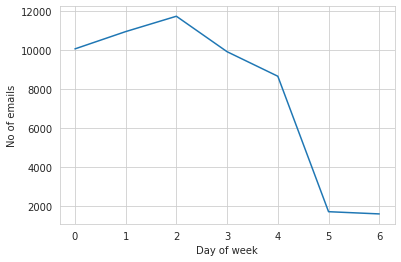

In [ ]:
day_of_week = df.groupby(df['Date'].dt.weekday)['content'].count().plot()
day_of_week.set_xlabel('Day of week', fontsize=10)
day_of_week.set_ylabel('No of emails', fontsize=10)
plt.show()

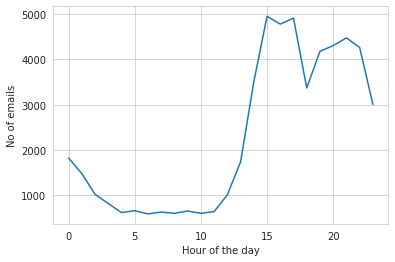

In [ ]:

hour_of_day = df.groupby(df['Date'].dt.hour)['content'].count().plot()
hour_of_day.set_xlabel('Hour of the day', fontsize=10)
hour_of_day.set_ylabel('No of emails', fontsize=10)
plt.show()

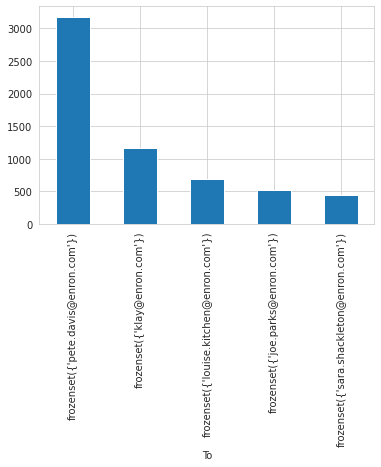

In [ ]:

frequent_sender = df.groupby(df['To'])['content'].count()
frequent_sender.sort_values(ascending=False)[:5].plot.bar()
plt.show()

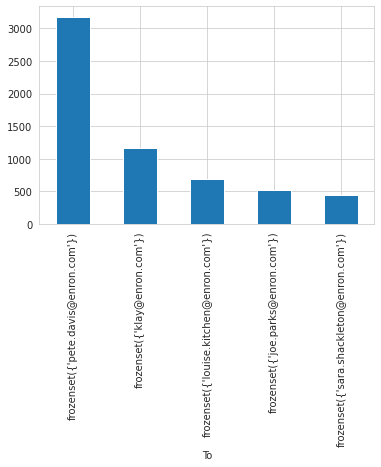

In [ ]:

frequent_recevier = df.groupby(df['From'])['content'].count()
frequent_sender.sort_values(ascending=False)[:5].plot.bar()
plt.show()

# Section 2: Sentiment Analysis

### Text Normalization :
after ignoring cases, removing stopwords, extra whitespaces and punctuations, we tried to reduce words to their stems. Used the PorterStemmer algorithm to perform word stemming on email text. The NLTK package has an implementation of this algorithm.

In [ ]:
  import nltk
  nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
tokenizer=RegexpTokenizer(r'\w+|\.')
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', '.', 'unknown','imag', 'http', 'com', 'id', 'srr', 'cc','time','one','let','get','thanks','would','call','please','know','date','iso','asp','click','pdf','html','www','com','enron','ena','gas','href','align','size','width','tr','br','td','font', 'gif','net','www','xls','ubs','see','doc'])

def clean_text(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r"\\", "", text)    
    text = re.sub(r"\'", "", text)    
    text = re.sub(r"\"", "", text)    
  
    text = re.sub("/(?<!\S).(?!\S)\s*/", " ", text) # removing single character spaces
    text = re.sub("\s\s+", " ", text) # removing multiple spaces

    text = text.strip().lower()
    text = ''.join([i for i in text if not i.isdigit()])
    filters='!"\'#$%&()*+,-/:;<=>?@[\\]^_`{|}~\t\n'
    translate_dict = dict((c, " ") for c in filters)
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)
    return text

In [ ]:
df['content'] = df['content'].apply(lambda x : clean_text(str(x)))
df['content'] = df['content'].apply(lambda x : tokenizer.tokenize(str(x)))
df['content'] = df['content'].apply(lambda x : [w for w in x if not w in stop_words])
#ps=PorterStemmer()
#df['content'] = df['content'].apply(lambda l : [ps.stem(w) for w in l])
# df['content'] = df['content'].apply(lambda x : " ".join(tokenizer.tokenize(str(x))))
df['content'] = [w for w in df['content'] if not w in stop_words] 
corpus=df['content'].tolist()

In [ ]:
corpus

In [ ]:
df['content']

0        greg thors phillip allen bishop corner sat dec...
1        request pend approv day itcapp corp srr auth e...
2        updat dec imag hard act follow futur ene rgi w...
3        resolut center decommiss number januari contin...
4        offic new year begin inform fundi meet day cov...
                               ...                        
54675    trade oil spec hedg ng john lavorato book john...
54676          posit alberta term book send posit directli
54677    origin messag doucet dawn sent wednesday novem...
54678    analyst rank stephan brodeur chad clark ian co...
54679    think ymca class peopl recov heart attack reme...
Name: content, Length: 54680, dtype: object

In [ ]:
  stop_models = [i for i in tokenized_models if str(i).lower() not in stopset

In [ ]:
from nltk.stem import LancasterStemmer, WordNetLemmatizer
def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

In [ ]:
def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
#Reduce the words to their stems
from nltk.tokenize import word_tokenize
df['content']=df['content'].apply(word_tokenize)

In [ ]:
df['content'][4]

['offic',
 'new',
 'year',
 'begin',
 'inform',
 'fundi',
 'meet',
 'day',
 'cover',
 'happen',
 'market',
 'sinc',
 'file',
 'bankruptci',
 'go',
 'pipelin',
 'flow',
 'storag',
 'balanc',
 'weather',
 'monthli',
 'daili',
 'price',
 'etc',
 'bank',
 'show',
 'interest',
 'show',
 'bid',
 'thought',
 'good',
 'us',
 'begin',
 'prepar',
 'trade',
 'market',
 'chri',
 'gaskil',
 'provid',
 'daili',
 'packet',
 'patti',
 'sullivan',
 'provid',
 'daili',
 'oper',
 'report',
 'think',
 'start',
 'around',
 'morn',
 'grigsbi']

# Email classification into negative/positive/neutral


We will now perform a sentiment analysis wherein we classify the emails into positive and negative in tone. We will use the NRC definition of words associated with positive and negative emotions to first extract the words associated with each emotion. Once we receive the total positive and total negative words from the email we perform a simple comparison to determine whether the email is:

           positive in tone (sentiment coding 1)
           negative in tone (sentiment coding -1)
           neutral in tone (sentiment coding 0)

  https://medium.com/@b.terryjack/nlp-pre-trained-sentiment-analysis-1eb52a9d742c

## NLTK

In [ ]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
# sid.polarity_scores(sentence)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
## Testing##
a = 'This was a good movie.'
sid.polarity_scores(a)

{'compound': 0.4404, 'neg': 0.0, 'neu': 0.508, 'pos': 0.492}

In [ ]:
df['content'].pop

<bound method Series.pop of 0        [greg, thors, phillip, allen, bishop, corner, ...
1        [request, pend, approv, day, itcapp, corp, srr...
2        [updat, dec, imag, hard, act, follow, futur, e...
3        [resolut, center, decommiss, number, januari, ...
4        [offic, new, year, begin, inform, fundi, meet,...
                               ...                        
54675    [trade, oil, spec, hedg, ng, john, lavorato, b...
54676    [posit, alberta, term, book, send, posit, dire...
54677    [origin, messag, doucet, dawn, sent, wednesday...
54678    [analyst, rank, stephan, brodeur, chad, clark,...
54679    [think, ymca, class, peopl, recov, heart, atta...
Name: content, Length: 54680, dtype: object>

In [ ]:
from nltk.stem.porter import PorterStemmer 
stemmer = PorterStemmer() 
df['stemmer'] = df['content'].apply(lambda x: [stemmer.stem(i) for i in x])
df.head(2)


,Unnamed: 0,file,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,user,stemmer
0,1232,allen-p/deleted_items/1.,<21543395.1075855374340.JavaMail.evans@thyme>,2001-12-30 18:19:42+00:00,frozenset({'pallen70@hotmail.com'}),frozenset({'pallen@enron.com'}),Fwd: Bishops Corner,1.0,text/plain; charset=ANSI_X3.4-1968,7bit,"""phillip allen"" <pallen70@hotmail.com>@ENRON",pallen@enron.com,NaN,NaN,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\Del...",Allen-P,pallen (Non-Privileged).pst,"[greg, thors, phillip, allen, bishop, corner, ...",allen-p,"[greg, thor, phillip, allen, bishop, corner, s..."
1,1233,allen-p/deleted_items/10.,<25363451.1075855374674.JavaMail.evans@thyme>,2001-12-28 01:16:46+00:00,frozenset({'arsystem@mailman.enron.com'}),frozenset({'k..allen@enron.com'}),Your Approval is Overdue: Access Request for m...,1.0,text/plain; charset=us-ascii,7bit,ARSystem <ARSystem@mailman.enron.com>@ENRON,"Allen, Phillip K. </O=ENRON/OU=NA/CN=RECIPIENT...",NaN,NaN,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\Del...",Allen-P,pallen (Non-Privileged).pst,"[request, pend, approv, day, itcapp, corp, srr...",allen-p,"[request, pend, approv, day, itcapp, corp, srr..."


In [ ]:
# SENTIMENT ANALYSIS NLTK VADER
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
def sentiment_analyze(stemmer):
  score = SentimentIntensityAnalyzer().polarity_scores(stemmer)
  neg = score['neg'] 
  pos = score['pos']
  neu = score['neu']

  return SentimentIntensityAnalyzer().polarity_scores(stemmer)

In [ ]:
df['polarity']= df['stemmer'].apply(sentiment_analyze)

In [ ]:
df['compound'] = df['polarity'].apply(lambda d:d['compound'])

In [ ]:
df['sentiment'] = df['compound'].apply(lambda score: 'positive' if score>=0.05 else 'negative' if score<=-0.05 else 'neutral')

In [ ]:
df.head(2)

,Unnamed: 0,file,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,user,stemmer,polarity,compound,sentiment
0,1232,allen-p/deleted_items/1.,<21543395.1075855374340.JavaMail.evans@thyme>,2001-12-30 18:19:42+00:00,frozenset({'pallen70@hotmail.com'}),frozenset({'pallen@enron.com'}),Fwd: Bishops Corner,1.0,text/plain; charset=ANSI_X3.4-1968,7bit,"""phillip allen"" <pallen70@hotmail.com>@ENRON",pallen@enron.com,NaN,NaN,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\Del...",Allen-P,pallen (Non-Privileged).pst,"[greg, thors, phillip, allen, bishop, corner, ...",allen-p,greg thor phillip allen bishop corner sat dec ...,"{'neg': 0.011, 'neu': 0.871, 'pos': 0.117, 'co...",0.9001,positive
1,1233,allen-p/deleted_items/10.,<25363451.1075855374674.JavaMail.evans@thyme>,2001-12-28 01:16:46+00:00,frozenset({'arsystem@mailman.enron.com'}),frozenset({'k..allen@enron.com'}),Your Approval is Overdue: Access Request for m...,1.0,text/plain; charset=us-ascii,7bit,ARSystem <ARSystem@mailman.enron.com>@ENRON,"Allen, Phillip K. </O=ENRON/OU=NA/CN=RECIPIENT...",NaN,NaN,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\Del...",Allen-P,pallen (Non-Privileged).pst,"[request, pend, approv, day, itcapp, corp, srr...",allen-p,request pend approv day itcapp corp srr auth e...,"{'neg': 0.059, 'neu': 0.868, 'pos': 0.073, 'co...",0.1280,positive


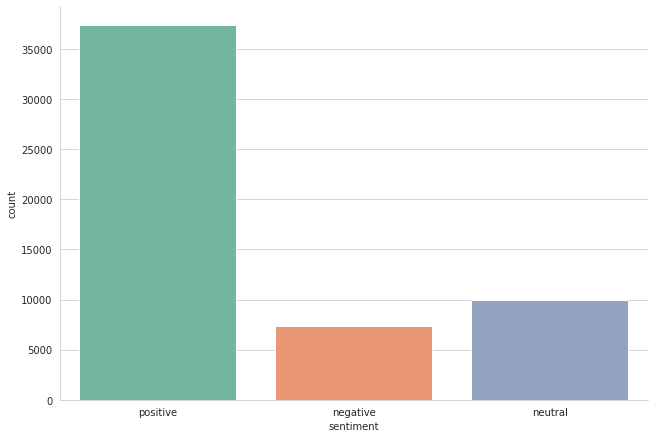

In [ ]:
import seaborn as sns

sns.catplot(x='sentiment', data=df, kind="count", height=6, aspect=1.5, palette="Set2")
plt.show()

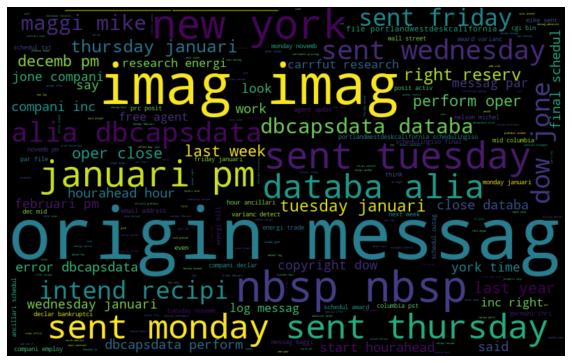

In [ ]:
# Word cloud
all_words = ' '.join([text for text in df['stemmer']])

from wordcloud import WordCloud 
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words) 

plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()

### ML MODEL

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm
from sklearn.metrics  import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:

sentiment_counts = df.sentiment.value_counts()
print(sentiment_counts)

positive    37375
neutral      9944
negative     7361
Name: sentiment, dtype: int64


In [ ]:
test_set = df[:4000]

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df['stemmer'][4000:], 
                                                  df['sentiment'][4000:], 
                                                  test_size=0.2)

y_test = test_set['sentiment']

In [ ]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_val = vectorizer.transform(X_val)
X_test = vectorizer.transform(test_set['stemmer'])

In [ ]:
print(f'Training size: {X_train.shape[0]} \n\
Validation size: {X_val.shape[0]} \n\
Test size: {X_test.shape[0]} \n\
Amount of words (columns): {X_train.shape[1]} words')

Training size: 40544 
Validation size: 10136 
Test size: 4000 
Amount of words (columns): 136148 words


### Multinomial Naive Bayes

In [ ]:

multi_nb = MultinomialNB()
multi_nb.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:

# Result
train_pred = multi_nb.predict(X_train)
val_pred = multi_nb.predict(X_val)
print(f'Accuracy on training set (MultinomialNB): {round(accuracy_score(y_train, train_pred)*100, 2)}%')
print(f'Accuracy on validation set (MultinomialNB): {round(accuracy_score(y_val,val_pred)*100, 2)}%')

Accuracy on training set (MultinomialNB): 72.62%
Accuracy on validation set (MultinomialNB): 71.83%


### SVM

In [ ]:
# Support Vector machine
svc = svm.SVC()
svc.fit(X_train,y_train)

In [ ]:
# Result
train_pred = svc.predict(X_train)
val_pred = svc.predict(X_val)
print(f'Accuracy on training set (SVC): {round(accuracy_score(y_train, train_pred)*100, 2)}%')
print(f'Accuracy on validation set (SVC): {round(accuracy_score(y_val,val_pred)*100, 2)}%')

Accuracy on training set (SVC): 97.73%
Accuracy on validation set (SVC): 91.46%


### Gradient Boosting Classifier (GBM)

In [ ]:
# sklearn's Gradient Boosting Classifier (GBM)
gbm = GradientBoostingClassifier(n_estimators=200, 
                                 max_depth=6) 
                              
gbm.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=6,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:

# Result
train_pred = gbm.predict(X_train)
val_pred = gbm.predict(X_val)
print(f'Accuracy on training set (GBM): {round(accuracy_score(y_train, train_pred)*100, 2)}%')
print(f'Accuracy on validation set (GBM): {round(accuracy_score(y_val,val_pred)*100, 2)}%')

Accuracy on training set (GBM): 96.03%
Accuracy on validation set (GBM): 92.87%


In [ ]:
# Multinomial Naive Bayes
multinb_test_pred = multi_nb.predict(X_test)

# Support Vector Machine 
svc_test_pred = svc.predict(X_test)

# Gradient Boosting Classifier
gbm_test_pred = gbm.predict(X_test)

In [ ]:

print(f'Accuracy for Multinomial Naive Bayes: {round(accuracy_score(y_test, multinb_test_pred)*100, 4)}%')
print(f'Accuracy for Support Vector Machine: {round(accuracy_score(y_test, svc_test_pred)*100, 4)}%')
print(f'Accuracy for Gradient Boosting Classifier: {round(accuracy_score(y_test, gbm_test_pred)*100, 4)}%')

Accuracy for Multinomial Naive Bayes: 73.475%
Accuracy for Support Vector Machine: 88.75%
Accuracy for Gradient Boosting Classifier: 92.125%


In [ ]:
pred_df = pd.DataFrame({'text':test_set['stemmer'],
                        'svc.predict':svc_test_pred,
                       'gbm.predict' :gbm_test_pred})

In [ ]:
pred_df['pred_agreement'] = (pred_df['gbm.predict']==pred_df['svc.predict'])
print(f"The models agree with each other {round(pred_df['pred_agreement'].value_counts()[1]/len(pred_df)*100, 4)}% of the time.")

The models agree with each other 91.95% of the time.


In [ ]:
pred_df.head()

,text,svc.predict,gbm.predict,pred_agreement
0,greg thor phillip allen bishop corner sat dec ...,positive,positive,True
1,request pend approv day itcapp corp srr auth e...,neutral,negative,False
2,updat dec imag hard act follow futur ene rgi w...,negative,negative,True
3,resolut center decommiss number januari contin...,positive,positive,True
4,offic new year begin inform fundi meet day cov...,positive,positive,True


In [ ]:
df.head(1)

,Unnamed: 0,file,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,user,stemmer,polarity,compound,sentiment
0,1232,allen-p/deleted_items/1.,<21543395.1075855374340.JavaMail.evans@thyme>,2001-12-30 18:19:42+00:00,frozenset({'pallen70@hotmail.com'}),frozenset({'pallen@enron.com'}),Fwd: Bishops Corner,1.0,text/plain; charset=ANSI_X3.4-1968,7bit,"""phillip allen"" <pallen70@hotmail.com>@ENRON",pallen@enron.com,NaN,NaN,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\Del...",Allen-P,pallen (Non-Privileged).pst,"[greg, thors, phillip, allen, bishop, corner, ...",allen-p,greg thor phillip allen bishop corner sat dec ...,"{'neg': 0.011, 'neu': 0.871, 'pos': 0.117, 'co...",0.9001,positive


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54680 entries, 0 to 54679
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   Unnamed: 0                 54680 non-null  int64              
 1   file                       54680 non-null  object             
 2   Message-ID                 54680 non-null  object             
 3   Date                       54680 non-null  datetime64[ns, UTC]
 4   From                       54680 non-null  object             
 5   To                         52452 non-null  object             
 6   Subject                    53427 non-null  object             
 7   Mime-Version               54677 non-null  float64            
 8   Content-Type               54677 non-null  object             
 9   Content-Transfer-Encoding  54677 non-null  object             
 10  X-From                     54677 non-null  object             
 11  X-

In [ ]:
df['To'] = df['To'].astype(pd.StringDtype())

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54680 entries, 0 to 54679
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   Unnamed: 0                 54680 non-null  int64              
 1   file                       54680 non-null  object             
 2   Message-ID                 54680 non-null  object             
 3   Date                       54680 non-null  datetime64[ns, UTC]
 4   From                       54680 non-null  object             
 5   To                         54680 non-null  string             
 6   Subject                    53427 non-null  object             
 7   Mime-Version               54677 non-null  float64            
 8   Content-Type               54677 non-null  object             
 9   Content-Transfer-Encoding  54677 non-null  object             
 10  X-From                     54677 non-null  object             
 11  X-

In [ ]:
df['count_To'] = df['To'].apply(lambda x: len(x.split(',')))
df.head(1)

,Unnamed: 0,file,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,user,stemmer,polarity,compound,sentiment,count_To
0,1232,allen-p/deleted_items/1.,<21543395.1075855374340.JavaMail.evans@thyme>,2001-12-30 18:19:42+00:00,frozenset({'pallen70@hotmail.com'}),frozenset({'pallen@enron.com'}),Fwd: Bishops Corner,1.0,text/plain; charset=ANSI_X3.4-1968,7bit,"""phillip allen"" <pallen70@hotmail.com>@ENRON",pallen@enron.com,NaN,NaN,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\Del...",Allen-P,pallen (Non-Privileged).pst,"[greg, thors, phillip, allen, bishop, corner, ...",allen-p,greg thor phillip allen bishop corner sat dec ...,"{'neg': 0.011, 'neu': 0.871, 'pos': 0.117, 'co...",0.9001,positive,1


In [ ]:
from google.colab import files

pred_df.to_csv('pred_df.csv')

files.download("pred_df.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Textblob

In [ ]:
from textblob import TextBlob
# TextBlob(sentence).sentiment

In [ ]:
df['scores2_TB'] = df['content'].apply(lambda content: TextBlob(str(content)).sentiment)
df.head(2)


,Unnamed: 0,file,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,user,stemmer,polarity,compound,sentiment,count_To,scores2_TB
0,1232,allen-p/deleted_items/1.,<21543395.1075855374340.JavaMail.evans@thyme>,2001-12-30 18:19:42+00:00,frozenset({'pallen70@hotmail.com'}),frozenset({'pallen@enron.com'}),Fwd: Bishops Corner,1.0,text/plain; charset=ANSI_X3.4-1968,7bit,"""phillip allen"" <pallen70@hotmail.com>@ENRON",pallen@enron.com,NaN,NaN,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\Del...",Allen-P,pallen (Non-Privileged).pst,"[greg, thors, phillip, allen, bishop, corner, ...",allen-p,greg thor phillip allen bishop corner sat dec ...,"{'neg': 0.011, 'neu': 0.871, 'pos': 0.117, 'co...",0.9001,positive,1,"(0.06911976911976911, 0.5489177489177489)"
1,1233,allen-p/deleted_items/10.,<25363451.1075855374674.JavaMail.evans@thyme>,2001-12-28 01:16:46+00:00,frozenset({'arsystem@mailman.enron.com'}),frozenset({'k..allen@enron.com'}),Your Approval is Overdue: Access Request for m...,1.0,text/plain; charset=us-ascii,7bit,ARSystem <ARSystem@mailman.enron.com>@ENRON,"Allen, Phillip K. </O=ENRON/OU=NA/CN=RECIPIENT...",NaN,NaN,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\Del...",Allen-P,pallen (Non-Privileged).pst,"[request, pend, approv, day, itcapp, corp, srr...",allen-p,request pend approv day itcapp corp srr auth e...,"{'neg': 0.059, 'neu': 0.868, 'pos': 0.073, 'co...",0.1280,positive,1,"(0.14285714285714285, 0.26785714285714285)"
2,1244,allen-p/deleted_items/11.,<8030945.1075855374698.JavaMail.evans@thyme>,2001-12-27 23:49:59+00:00,frozenset({'ei_editor@platts.com'}),frozenset({'einsighthtml@listserv.platts.com'}),A hard act to follow: the future for energy wi...,1.0,text/plain; charset=ANSI_X3.4-1968,quoted-printable,Energy Insight Editor <EI_editor@PLATTS.COM>@E...,EINSIGHTHTML@LISTSERV.PLATTS.COM,NaN,NaN,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\Del...",Allen-P,pallen (Non-Privileged).pst,"[updat, dec, imag, hard, act, follow, futur, e...",allen-p,updat dec imag hard act follow futur ene rgi w...,"{'neg': 0.098, 'neu': 0.861, 'pos': 0.041, 'co...",-0.9559,negative,1,"(0.1405032467532468, 0.5127886002886005)"
3,1254,allen-p/deleted_items/12.,<20180566.1075855374772.JavaMail.evans@thyme>,2001-12-27 23:37:31+00:00,frozenset({'no.address@enron.com'}),nan,Please Read: Resolution Center to Disconnect T...,1.0,text/plain; charset=ANSI_X3.4-1968,7bit,Enron General Announcements@ENRON,Announcement Group@ENRON <??SAnnouncement Grou...,NaN,NaN,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\Del...",Allen-P,pallen (Non-Privileged).pst,"[resolut, center, decommiss, number, januari, ...",allen-p,resolut center decommiss number januari contin...,"{'neg': 0.0, 'neu': 0.892, 'pos': 0.108, 'comp...",0.8020,positive,1,"(2.7755575615628915e-18, 0.24000000000000005)"
4,1265,allen-p/deleted_items/13.,<6589757.1075855374796.JavaMail.evans@thyme>,2001-12-27 15:37:45+00:00,frozenset({'mike.grigsby@enron.com'}),"frozenset({'m..tholt@enron.com', 'patti.sulliv...",FUNDIES MEETING EVERY DAY BEGINNING NEXT WEEK,1.0,text/plain; charset=us-ascii,7bit,"Grigsby, Mike </O=ENRON/OU=NA/CN=RECIPIENTS/CN...","Adams, Jacqueline P. </O=ENRON/OU=NA/CN=RECIPI...",NaN,NaN,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\Del...",Allen-P,pallen (Non-Privileged).pst,"[offic, new, year, begin, inform, fundi, meet,...",allen-p,offic new year begin inform fundi meet day cov...,"{'neg': 0.0, 'neu': 0.894, 'pos': 0.106, 'comp...",0.7096,positive,20,"(0.41818181818181815, 0.5272727272727273)"


In [ ]:
# defining function for subjectivity 
def getSubjectivity(txt):
  return TextBlob(txt).sentiment.subjectivity

# defining function for Polarity
def getPolarity(txt):
  return TextBlob(txt).sentiment.polarity

In [ ]:
# Adding Sentiment crossponding each mail
df['TB_Subjectivity'] = df['stemmer'].apply(getSubjectivity)

df['TB_Polarity'] = df['stemmer'].apply(getPolarity)

# displaying data 
df.head(2)

,Unnamed: 0,file,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,user,stemmer,polarity,compound,sentiment,count_To,scores2_TB,TB_Subjectivity,TB_Polarity
0,1232,allen-p/deleted_items/1.,<21543395.1075855374340.JavaMail.evans@thyme>,2001-12-30 18:19:42+00:00,frozenset({'pallen70@hotmail.com'}),frozenset({'pallen@enron.com'}),Fwd: Bishops Corner,1.0,text/plain; charset=ANSI_X3.4-1968,7bit,"""phillip allen"" <pallen70@hotmail.com>@ENRON",pallen@enron.com,NaN,NaN,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\Del...",Allen-P,pallen (Non-Privileged).pst,"[greg, thors, phillip, allen, bishop, corner, ...",allen-p,greg thor phillip allen bishop corner sat dec ...,"{'neg': 0.011, 'neu': 0.871, 'pos': 0.117, 'co...",0.9001,positive,1,"(0.06911976911976911, 0.5489177489177489)",0.548918,0.069120
1,1233,allen-p/deleted_items/10.,<25363451.1075855374674.JavaMail.evans@thyme>,2001-12-28 01:16:46+00:00,frozenset({'arsystem@mailman.enron.com'}),frozenset({'k..allen@enron.com'}),Your Approval is Overdue: Access Request for m...,1.0,text/plain; charset=us-ascii,7bit,ARSystem <ARSystem@mailman.enron.com>@ENRON,"Allen, Phillip K. </O=ENRON/OU=NA/CN=RECIPIENT...",NaN,NaN,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\Del...",Allen-P,pallen (Non-Privileged).pst,"[request, pend, approv, day, itcapp, corp, srr...",allen-p,request pend approv day itcapp corp srr auth e...,"{'neg': 0.059, 'neu': 0.868, 'pos': 0.073, 'co...",0.1280,positive,1,"(0.14285714285714285, 0.26785714285714285)",0.267857,0.142857


In [ ]:

# Define function for analyzing Polarity
def getAnalysis(score):
  if score < 0:
    return 'Negative'
  elif score == 0 :
    return 'Neutral'
  else:
    return 'Positive'

In [ ]:

# Create Analysis column based on polarity
df['TB_Analysis'] = df['TB_Polarity'].apply(getAnalysis)

# diplay data
df.head(1)

,Unnamed: 0,file,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,user,stemmer,polarity,compound,sentiment,count_To,scores2_TB,TB_Subjectivity,TB_Polarity,TB_Analysis
0,1232,allen-p/deleted_items/1.,<21543395.1075855374340.JavaMail.evans@thyme>,2001-12-30 18:19:42+00:00,frozenset({'pallen70@hotmail.com'}),frozenset({'pallen@enron.com'}),Fwd: Bishops Corner,1.0,text/plain; charset=ANSI_X3.4-1968,7bit,"""phillip allen"" <pallen70@hotmail.com>@ENRON",pallen@enron.com,NaN,NaN,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\Del...",Allen-P,pallen (Non-Privileged).pst,"[greg, thors, phillip, allen, bishop, corner, ...",allen-p,greg thor phillip allen bishop corner sat dec ...,"{'neg': 0.011, 'neu': 0.871, 'pos': 0.117, 'co...",0.9001,positive,1,"(0.06911976911976911, 0.5489177489177489)",0.548918,0.06912,Positive


### Flair

In [ ]:
!pip3 install flair
import flair
flair_sentiment = flair.models.TextClassifier.load('en-sentiment')
#s = flair.data.Sentence(sentence)
#flair_sentiment.predict(s)
#total_sentiment = s.labels
#total_sentiment

     |████████████████████████████████| 337kB 4.7MB/s 
     |████████████████████████████████| 1.1MB 14.4MB/s 
     |████████████████████████████████| 276kB 29.5MB/s 
     |████████████████████████████████| 71kB 9.4MB/s 
     |████████████████████████████████| 19.7MB 43.6MB/s 
     |████████████████████████████████| 798kB 52.5MB/s 
     |████████████████████████████████| 983kB 43.2MB/s 
     |████████████████████████████████| 1.1MB 44.0MB/s 
     |████████████████████████████████| 3.0MB 47.8MB/s 
     |████████████████████████████████| 890kB 41.8MB/s 
  Created wheel for segtok: filename=segtok-1.5.10-cp36-none-any.whl size=25021 sha256=56dcfa4ae7b056642097fdfb9846f902579417ab6fe2b314109eed026832ac53
  Stored in directory: /root/.cache/pip/wheels/b4/39/f6/9ca1c5cabde964d728023b5751c3a206a5c8cc40252321fb6b
  Created wheel for sqlitedict: filename=sqlitedict-1.7.0-cp36-none-any.whl size=14377 sha256=c530acbf2ea3f75877cd4195eea4963aa666abdd9cfdab28a857e568e74cbb9b
  Stored in directory: /

100%|██████████| 266147697/266147697 [00:31<00:00, 8481380.57B/s]

2020-09-30 10:02:00,770 copying /tmp/tmpjihxy71u to cache at /root/.flair/models/sentiment-en-mix-distillbert_3.1.pt


2020-09-30 10:02:01,291 removing temp file /tmp/tmpjihxy71u
2020-09-30 10:02:01,685 loading file /root/.flair/models/sentiment-en-mix-distillbert_3.1.pt


In [ ]:
'''s = flair.data.Sentence(sentence)
flair_sentiment.predict(s)
total_sentiment = s.labels
total_sentiment'''

s = flair.data.Sentence(str(df['content']))
df['scores3_Flair'] = df['content'].apply(lambda content: s)
flair_sentiment.predict(s)
total_sentiment = s.labels
total_sentiment
df.head()


,Unnamed: 0,file,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,user,stemmer,polarity,compound,sentiment,count_To,scores2_TB,TB_Subjectivity,TB_Polarity,TB_Analysis,scores3_Flair
0,1232,allen-p/deleted_items/1.,<21543395.1075855374340.JavaMail.evans@thyme>,2001-12-30 18:19:42+00:00,frozenset({'pallen70@hotmail.com'}),frozenset({'pallen@enron.com'}),Fwd: Bishops Corner,1.0,text/plain; charset=ANSI_X3.4-1968,7bit,"""phillip allen"" <pallen70@hotmail.com>@ENRON",pallen@enron.com,NaN,NaN,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\Del...",Allen-P,pallen (Non-Privileged).pst,"[greg, thors, phillip, allen, bishop, corner, ...",allen-p,greg thor phillip allen bishop corner sat dec ...,"{'neg': 0.011, 'neu': 0.871, 'pos': 0.117, 'co...",0.9001,positive,1,"(0.06911976911976911, 0.5489177489177489)",0.548918,6.911977e-02,Positive,"(Token: 1 0, Token: 2 [, Token: 3 greg, Token:..."
1,1233,allen-p/deleted_items/10.,<25363451.1075855374674.JavaMail.evans@thyme>,2001-12-28 01:16:46+00:00,frozenset({'arsystem@mailman.enron.com'}),frozenset({'k..allen@enron.com'}),Your Approval is Overdue: Access Request for m...,1.0,text/plain; charset=us-ascii,7bit,ARSystem <ARSystem@mailman.enron.com>@ENRON,"Allen, Phillip K. </O=ENRON/OU=NA/CN=RECIPIENT...",NaN,NaN,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\Del...",Allen-P,pallen (Non-Privileged).pst,"[request, pend, approv, day, itcapp, corp, srr...",allen-p,request pend approv day itcapp corp srr auth e...,"{'neg': 0.059, 'neu': 0.868, 'pos': 0.073, 'co...",0.1280,positive,1,"(0.14285714285714285, 0.26785714285714285)",0.267857,1.428571e-01,Positive,"(Token: 1 0, Token: 2 [, Token: 3 greg, Token:..."
2,1244,allen-p/deleted_items/11.,<8030945.1075855374698.JavaMail.evans@thyme>,2001-12-27 23:49:59+00:00,frozenset({'ei_editor@platts.com'}),frozenset({'einsighthtml@listserv.platts.com'}),A hard act to follow: the future for energy wi...,1.0,text/plain; charset=ANSI_X3.4-1968,quoted-printable,Energy Insight Editor <EI_editor@PLATTS.COM>@E...,EINSIGHTHTML@LISTSERV.PLATTS.COM,NaN,NaN,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\Del...",Allen-P,pallen (Non-Privileged).pst,"[updat, dec, imag, hard, act, follow, futur, e...",allen-p,updat dec imag hard act follow futur ene rgi w...,"{'neg': 0.098, 'neu': 0.861, 'pos': 0.041, 'co...",-0.9559,negative,1,"(0.1405032467532468, 0.5127886002886005)",0.512789,1.405032e-01,Positive,"(Token: 1 0, Token: 2 [, Token: 3 greg, Token:..."
3,1254,allen-p/deleted_items/12.,<20180566.1075855374772.JavaMail.evans@thyme>,2001-12-27 23:37:31+00:00,frozenset({'no.address@enron.com'}),nan,Please Read: Resolution Center to Disconnect T...,1.0,text/plain; charset=ANSI_X3.4-1968,7bit,Enron General Announcements@ENRON,Announcement Group@ENRON <??SAnnouncement Grou...,NaN,NaN,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\Del...",Allen-P,pallen (Non-Privileged).pst,"[resolut, center, decommiss, number, januari, ...",allen-p,resolut center decommiss number januari contin...,"{'neg': 0.0, 'neu': 0.892, 'pos': 0.108, 'comp...",0.8020,positive,1,"(2.7755575615628915e-18, 0.24000000000000005)",0.240000,2.775558e-18,Positive,"(Token: 1 0, Token: 2 [, Token: 3 greg, Token:..."
4,1265,allen-p/deleted_items/13.,<6589757.1075855374796.JavaMail.evans@thyme>,2001-12-27 15:37:45+00:00,frozenset({'mike.grigsby@enron.com'}),"frozenset({'m..tholt@enron.com', 'patti.sulliv...",FUNDIES MEETING EVERY DAY BEGINNING NEXT WEEK,1.0,text/plain; charset=us-ascii,7bit,"Grigsby, Mike </O=ENRON/OU=NA/CN=RECIPIENTS/CN...","Adams, Jacqueline P. </O=ENRON/OU=NA/CN=RECIPI...",NaN,NaN,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\Del...",Allen-P,pallen (Non-Privileged).pst,"[offic, new, year, begin, inform, fundi, meet,...",allen-p,offic new year begin inform fundi meet day cov...,"{'neg': 0.0, 'neu': 0.894, 'pos': 0.106, 'comp...",0.7096,positive,20,"(0.41818181818181815, 0.5272727272727273)",0.527273,4.181818e-01,Positive,"(Toke

In [ ]:
df.scores3_Flair.unique()

array([Sentence: "0 [ greg , thors , phillip , allen , bishop , corner , ... 1 [ request , pend , approv , day , itcapp , corp , srr ... 2 [ updat , dec , imag , hard , act , follow , futur , e ... 3 [ resolut , center , decommiss , number , januari , ... 4 [ offic , new , year , begin , inform , fundi , meet ,.. . ... 54675 [ trade , oil , spec , hedg , ng , john , lavorato , b ... 54676 [ posit , alberta , term , book , send , posit , dire ... 54677 [ origin , messag , doucet , dawn , sent , wednesday ... 54678 [ analyst , rank , stephan , brodeur , chad , clark ,.. . 54679 [ think , ymca , class , peopl , recov , heart , atta ... Name : content , Length : 54680 , dtype : object"   [− Tokens: 170  − Sentence-Labels: {'label': [NEGATIVE (0.9974)]}]],
      dtype=object)

In [ ]:
df['scores3_Flair'].pop

<bound method Series.pop of 0        (Token: 1 0, Token: 2 [, Token: 3 greg, Token:...
1        (Token: 1 0, Token: 2 [, Token: 3 greg, Token:...
2        (Token: 1 0, Token: 2 [, Token: 3 greg, Token:...
3        (Token: 1 0, Token: 2 [, Token: 3 greg, Token:...
4        (Token: 1 0, Token: 2 [, Token: 3 greg, Token:...
                               ...                        
54675    (Token: 1 0, Token: 2 [, Token: 3 greg, Token:...
54676    (Token: 1 0, Token: 2 [, Token: 3 greg, Token:...
54677    (Token: 1 0, Token: 2 [, Token: 3 greg, Token:...
54678    (Token: 1 0, Token: 2 [, Token: 3 greg, Token:...
54679    (Token: 1 0, Token: 2 [, Token: 3 greg, Token:...
Name: scores3_Flair, Length: 54680, dtype: object>

In [ ]:
df.head(1)

,Unnamed: 0,file,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,user,stemmer,polarity,compound,sentiment,count_To,scores2_TB,TB_Subjectivity,TB_Polarity,TB_Analysis,scores3_Flair
0,1232,allen-p/deleted_items/1.,<21543395.1075855374340.JavaMail.evans@thyme>,2001-12-30 18:19:42+00:00,frozenset({'pallen70@hotmail.com'}),frozenset({'pallen@enron.com'}),Fwd: Bishops Corner,1.0,text/plain; charset=ANSI_X3.4-1968,7bit,"""phillip allen"" <pallen70@hotmail.com>@ENRON",pallen@enron.com,NaN,NaN,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\Del...",Allen-P,pallen (Non-Privileged).pst,"[greg, thors, phillip, allen, bishop, corner, ...",allen-p,greg thor phillip allen bishop corner sat dec ...,"{'neg': 0.011, 'neu': 0.871, 'pos': 0.117, 'co...",0.9001,positive,1,"(0.06911976911976911, 0.5489177489177489)",0.548918,0.06912,Positive,"(Token: 1 0, Token: 2 [, Token: 3 greg, Token:..."


In [ ]:
from google.colab import files

df.to_csv('df_score.csv')

files.download("df_score.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>